# Infering the size of a cube galaxy from the inside

written by Tristan Cantat-Gaudin - last edit 2023-10-27

Toy model: imagine we are inside a cube-shaped galaxy with edge length $a$. The positions of the stars in $(X,Y,Z)$ cartesian coordinates are all limited to $[-\frac{a}{2},\frac{a}{2}]$. 

For this exercise we don't measure the distances to the stars, only their apparent position $(\ell,b)$ on the sky. We know we are sitting inside the cube, because there are stars all around us, and we know we are located 8 kpc from the centre of the cube. Can we estimate the size of the galaxy just by looking at the distribution of stars on the sky? 

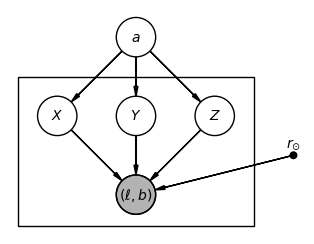

In [1]:
import daft

# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
pgm.add_node("rsun", r"$r_{\odot}$", 4, 0.5, fixed=True)
pgm.add_node("a", r"$a$", 2, 2)


# Latent variable.
pgm.add_node("x", r"$X$", 1, 1)
pgm.add_node("y", r"$Y$", 2, 1)
pgm.add_node("z", r"$Z$", 3, 1)

# Data.
pgm.add_node("lb", r"$(\ell,b)$", 2, 0, observed=True)

# Add in the edges.
pgm.add_edge("rsun", "lb")
pgm.add_edge("x", "lb")
pgm.add_edge("y", "lb")
pgm.add_edge("z", "lb")
pgm.add_edge("a", "x")
pgm.add_edge("a", "y")
pgm.add_edge("a", "z")

# And a plate.
pgm.add_plate([0.5, -0.5, 3, 2], label=r"", shift=0.1)

# Render:
pgm.render();

Inside the box: the sky positions $(\ell,b)$ are **observed quantities**: they are the pieces of information we have measured, and we will use to test our understanding of the Milky Way. The 3D positions $(X,Y,Z)$ are called **latent variables**: we don't know them for individual stars, and we are not even trying to calculate them.

Outside the box: $r_{\odot}$ is a fixed quantity. We believe we know the value of the distance to the Galactic centre to a good precision (at least compared to the other parameters) so we fix it to 8\,kpc. The parameter $a$ (edge length of the cube) is the only free parameter in this model. 

**Note:** if we don't know the distance to the Galactic centre then it is impossible to estimate the size of the cube by looking at positions alone. In the real Milky Way it turns out that measuring the distance to the Galactic centre is easier than estimating the overall shape of our Galaxy because the supermassive black hole Sgr A* is sitting right at the centre and emits strong radio emissions for which distances can be measured. Many studies of Milky Way structure use a fix value for the distance to the centre (approx. 8.2 kpc, [GRAVITY collaboration 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...625L..10G/abstract)) so this part of exercise is not unrealistic.

## Pick random points to create our simulated Galaxy:

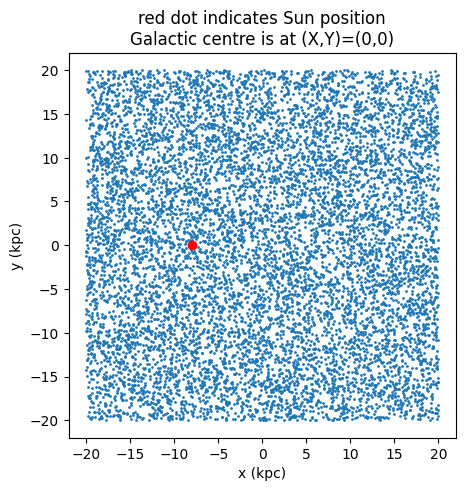

In [2]:
import numpy as np

np.random.seed(100)

nbStars = 10000

halfSizeCube = 20 #
x = np.random.uniform(low=-halfSizeCube,high=halfSizeCube, size=nbStars)
y = np.random.uniform(low=-halfSizeCube,high=halfSizeCube, size=nbStars)
z = np.random.uniform(low=-halfSizeCube,high=halfSizeCube, size=nbStars)

import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u

# convert to ICRS
all_stars = SkyCoord(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc,
               frame=coord.Galactocentric(galcen_distance=8*u.kpc,z_sun=0*u.kpc), representation_type='cartesian', differential_type='cartesian')

all_stars_ICRS = all_stars.transform_to(coord.ICRS)
all_stars_Galactic = all_stars.transform_to(coord.Galactic)

# The stars have a distance attribute now!
plt.figure(figsize=(5,5))
plt.scatter( x , y , s=1 )
plt.scatter([-8],[0],c='r')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')

plt.title('red dot indicates Sun position\nGalactic centre is at (X,Y)=(0,0)');

This is what our cube Galaxy would look like on the sky:

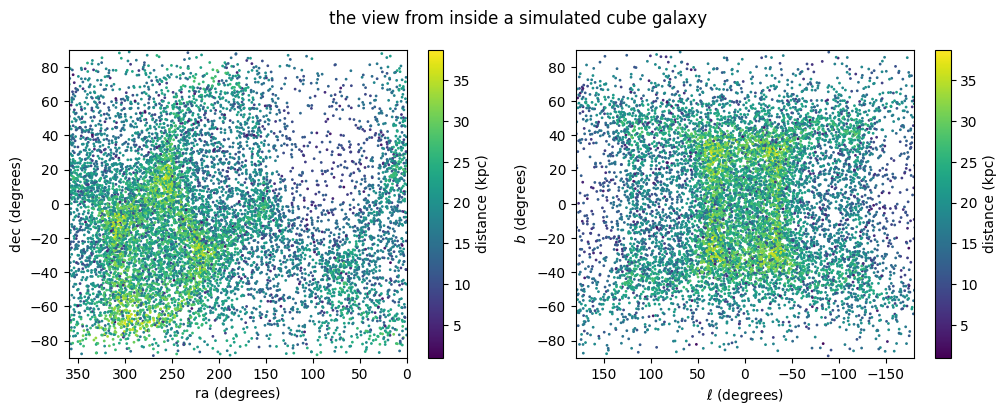

In [3]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter( all_stars_ICRS.ra.value, all_stars_ICRS.dec.value, c=all_stars_ICRS.distance.value, s=1 )
plt.xlabel('ra (degrees)'); plt.ylabel('dec (degrees)')
plt.colorbar(label='distance (kpc)')
plt.xlim(360,0)
plt.ylim(-90,90)

plt.subplot(122)
plt.scatter( all_stars_Galactic.l.value, all_stars_Galactic.b.value, c=all_stars_Galactic.distance.value, s=1 )
plt.scatter( all_stars_Galactic.l.value - 360 , all_stars_Galactic.b.value, c=all_stars_Galactic.distance.value, s=1 )
plt.xlim(180,-180)
plt.ylim(-90,90)
plt.xlabel('$\ell$ (degrees)'); plt.ylabel('$b$ (degrees)')
plt.colorbar(label='distance (kpc)')

plt.suptitle('the view from inside a simulated cube galaxy');

## Writing down the likelihood

We are going to estimate the size of the cube galaxy through a maximum-likelihood approach. For any given size $a$, we can calculate a ''probability'' that it can generate a star at location $(\ell,b)$ on the sky. The probability density at a given location on the sky can be calculated as the distance from the edge of the cube in that direction. The value of $\ell$ tells us which face we are facing. In the next cell I define the function `probability_density_cube` to compute this probability density distribution. 

In order to represent a probability density, this function must be normalised to 1: a star has a 100% probability of being *somewhere* on the sky. In mathematical terms, we need to calculate the integral of `probability_density_cube` over the whole sky. A lazy way to calculate this normalisation constant is to evaluate `probability_density_cube` at many locations (I will use healpix regions here) add up all the values. 

**Note:** in a real-life situation you would probably use a model with an exponential disc, or a sum of different components, with astrophysical meaning. That model would generally be expressed in Galactic cylindrical coordinates, and you would need to take into account coordinate transformations and associated Jacobians to make it work. Here I chose a cube with hard edges, for which the likelihood is easier to write down.

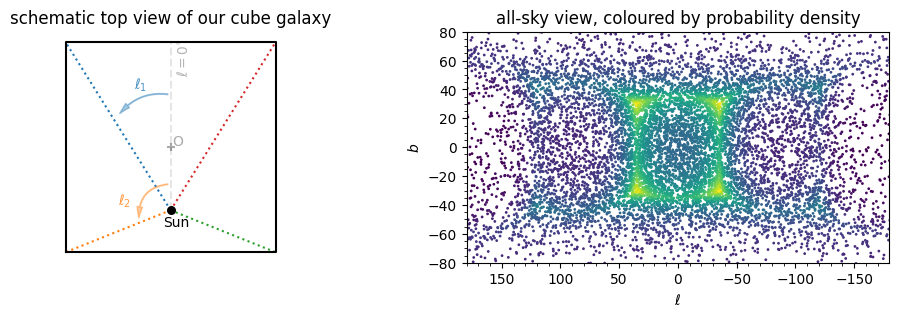

In [4]:
import matplotlib.patches as patches # to add arrows

plt.figure(figsize=(12,3))

plt.subplot(121,aspect=1.)
plt.plot( [-1,1,1,-1,-1] , [-1,-1,1,1,-1] , 'k-' ) #cube outline
plt.scatter(0,0,marker='+',c='#aaaaaa') #galactic centre
plt.scatter(0,-0.6,s=30,c='k',zorder=10) # Sun
# dashed lines to corners
plt.plot([0,-1],[-0.6,1],':',c='C0',zorder=1)
plt.plot([0,-1],[-0.6,-1],':',c='C1',zorder=1)
plt.plot([0,1],[-0.6,-1],':',c='C2',zorder=1)
plt.plot([0,1],[-0.6,1],':',c='C3',zorder=1)
plt.axis('off')
plt.title('schematic top view of our cube galaxy')

# annotations
plt.text(0.02,0.02,'O',c='#aaaaaa')
plt.text(-0.07,-0.75,'Sun')
plt.plot([0,0],[-0.6,1],'k--',alpha=0.1) # ell=0 line
plt.text(0.05,0.7,'$\ell=0^{\circ}$',rotation=90,alpha=0.3)

# arrow for ell_1
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="C0",alpha=0.4)
arrow_l = patches.FancyArrowPatch((0., 0.5), (-0.5, 0.3), connectionstyle="arc3,rad=.3", **kw)
plt.gca().add_patch(arrow_l)
plt.text(-0.35, 0.55,'$\ell_1$', color="C0",alpha=0.8)
# arrow for ell_2
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="C1",alpha=0.4)
arrow_l = patches.FancyArrowPatch((0., -0.35), (-0.3, -0.7), connectionstyle="arc3,rad=.5", **kw)
plt.gca().add_patch(arrow_l)
plt.text(-0.5, -0.55,'$\ell_2$', color="C1",alpha=0.8)





def probability_density_cube(l,b,a,Rsun=8):
    """Input:
            l: Galactic longitude (in degrees)
            b: Galactic latitude (in degrees)
            a: size of the cube edge (in kpc)
            Rsun: the distance to the Galactic centre
        
        Output:
            probability density at that location
            
        This assumes the Sun is sitting at (X,Y,Z)=(-Rsun,0,0).
        
        The cube extends from -a/2 to +a/2 in all three dimensions.
        
        The function computes the distance to the cube wall in direction (l,b),
        divided by the total volume of the cube.
        """
    # Noting ell_1,2,3,4 the longitude of the four vertical vertices of the cube:
    # (in degrees)
    ell_1 = 360.*np.arctan( (a/2.)/((a/2.)+Rsun) )/(2*np.pi)
    ell_2 = 180 - 360.*np.arctan( (a/2.)/((a/2.)-Rsun) )/(2*np.pi)
    ell_3 = 360 - ell_2   
    ell_4 = 360 - ell_1
    # print(ell_1,ell_2,ell_3,ell_4)
    
    
    # first calculate the horizontal distance dH to the wall we are facing:
    if l<ell_1: #front face
        dH = (Rsun + a/2.) / np.cos(np.radians(l))
    elif l<ell_2:
        dH = (a/2.) / np.cos( np.radians(90-l))
    elif l<ell_3: #back face
        dH = ((a/2.)-Rsun) / np.cos(np.radians(180-l))
    elif l<ell_4:
        dH = (a/2.) / np.cos( np.radians(90+l))           
    else: #front face
        dH = (Rsun + a/2.) / np.cos(np.radians(l))
        
    # then take latitude into account:
    d = dH / np.cos(np.radians(b))
    
    # finally, check if that particular line of sight hits the floor or ceiling of the cube:
    if b==0:
        return d**3
    else:
        d_ceiling_or_floor = np.abs((a/2.) / np.sin(np.radians(b)))

        if (d<d_ceiling_or_floor):
            return d**3
        else:
            return d_ceiling_or_floor**3

    
ddd = []
for iii in range(len(all_stars_Galactic.l.value)):
    ddd.append( probability_density_cube(all_stars_Galactic.l.value[iii],all_stars_Galactic.b.value[iii],40) )

    
plt.subplot(122)
plt.scatter( all_stars_Galactic.l.value, all_stars_Galactic.b.value, c=ddd, s=1 )
plt.scatter( all_stars_Galactic.l.value - 360 , all_stars_Galactic.b.value, c=ddd, s=1 )
plt.xlim(180,-180)
plt.ylim(-80,80)
plt.xlabel('$\ell$'); plt.ylabel('$b$')
plt.minorticks_on()
plt.title('all-sky view, coloured by probability density');

# Maximum likelihood estimation from positions $(\ell,b)$

We have a function `𝚙𝚛𝚘𝚋𝚊𝚋𝚒𝚕𝚒𝚝𝚢_𝚍𝚎𝚗𝚜𝚒𝚝𝚢_𝚌𝚞𝚋𝚎` that gives us, for a given choice of cube size $a$, the probability density distribution as a function of $\ell$ and $b$:

$$\mathcal{L}_i (a) = \mathtt{probability\,density\,cube}(\ell_i,b_i,a)$$

And the combined likelihood is the product:

$$\mathcal{L} (a) = \displaystyle\prod_i \mathtt{probability\,density\,cube}(\ell_i,b_i,a) $$


In practice computers don't like it when you multiply thousands or millions of small values, so we calculate the sum of the logarithm of those small values:

$$\log \mathcal{L} (a) = \displaystyle\sum_i \log \mathtt{probability\,density\,cube}(\ell_i,b_i,a) $$

If we calculate this quantity for different values of $a$, we which values are more likely than others to be the correct model.

**Note:** There are more efficient ways of finding the best $a$, especially in cases with many free parameters. If all you care about, `scipy` has modules to minimise/maximise functions. If your function has many variables and you want to explore all possible combinations, MCMC optimisation (e.g. `emcee`) works great. Here we are just going to try many different values of $a$ and see which one produces the highest (log-)likelihood. 

30 316829973.38885546 -106286.01156802248
35 503122323.9348422 -105979.86632418261
40 750992110.8696713 -105907.59456255619
45 1069285435.7912118 -105932.13663716316
50 1466789988.6878312 -105995.42518501406
55 1952268279.7793093 -106072.3044651955
CPU times: user 38.7 s, sys: 230 ms, total: 38.9 s
Wall time: 38.7 s


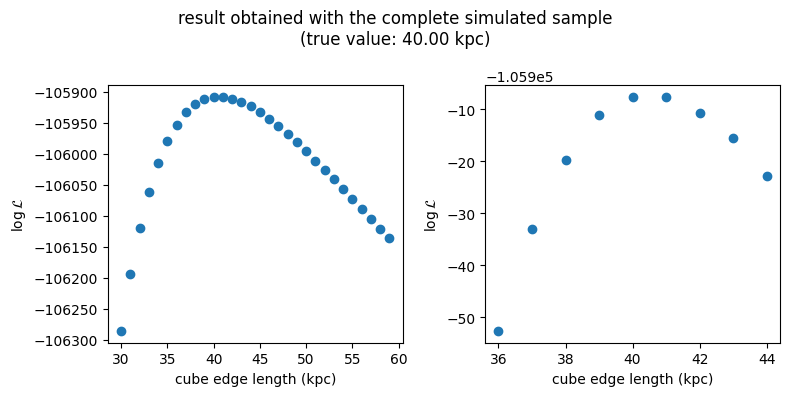

In [5]:
%%time

cube_sizes_to_try = np.arange(30,60,1)

# Build a grid of points over the sky, to later compute the normalisation:
import healpy as hp
order = 6
nside = hp.order2nside(order)
npix = hp.order2npix(order)
ipix = np.arange(npix)
l_hpx, b_hpx = hp.pix2ang(nside, ipix, lonlat=True)



all_log_L = []
for cubeSize in cube_sizes_to_try:

    density_on_grid = []
    # compute the normalisation constant:
    for ll_hpx,bb_hpx in zip(l_hpx, b_hpx):
        p_grid = probability_density_cube(ll_hpx, bb_hpx,cubeSize,Rsun=8)
        density_on_grid.append( p_grid )
    norm_constant = sum(density_on_grid)
    
    # compute the likelihood for all stars one by one:
    log_p = []
    for iii in range(len(all_stars_Galactic.l.value)):
        p = probability_density_cube(all_stars_Galactic.l.value[iii],all_stars_Galactic.b.value[iii],cubeSize,Rsun=8) 
        log_p.append( np.log(p/norm_constant) )
        
    all_log_L.append( sum(log_p) )
    if cubeSize%5==0:
        print(cubeSize,norm_constant,sum(log_p))
all_log_L = np.array(all_log_L)








plt.figure(figsize=(8,4))

plt.subplot(121)
plt.scatter( cube_sizes_to_try , all_log_L )   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

imax = np.argmax(all_log_L)
plt.subplot(122)
plt.scatter( cube_sizes_to_try[imax-4:imax+5] , all_log_L[imax-4:imax+5] )   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

plt.suptitle('result obtained with the complete simulated sample\n(true value: %.2f kpc)' % (2*halfSizeCube))
plt.tight_layout()

## What if our data is incomplete?

We are going to remove part of our data, to simulate the fact that some parts of the sky might be more complete than others. For this example I use the selection function model of Gaia DR3, computed at magnitude $G=21$. In real life, the completeness often also depends on magnitude, but here I just assume that the completeness depends on the location on the sky.

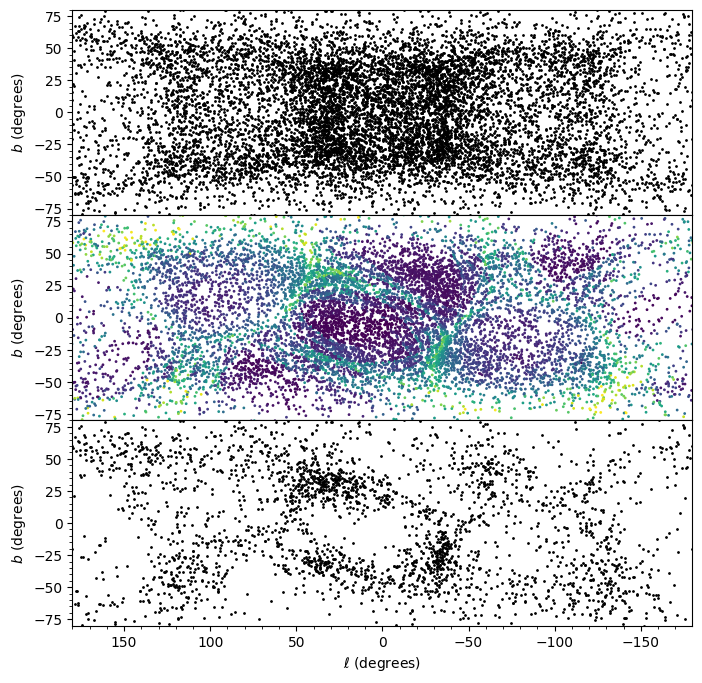

In [6]:
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG
mapHpx7 = DR3SelectionFunctionTCG()

gmag = 21.2
all_gmag = gmag*np.ones_like(all_stars_Galactic)
completeness = mapHpx7.query(all_stars_Galactic,all_gmag)

plt.figure(figsize=(8,8))

plt.subplot(311)
plt.scatter( all_stars_Galactic.l.value, all_stars_Galactic.b.value, c='k', s=1 )
plt.scatter( all_stars_Galactic.l.value - 360 , all_stars_Galactic.b.value, c='k', s=1 )
plt.xlim(180,-180)
plt.ylim(-80,80)
plt.ylabel('$b$ (degrees)')
plt.minorticks_on()


plt.subplot(312)
plt.scatter( all_stars_Galactic.l.value, all_stars_Galactic.b.value, c=completeness, s=1,vmin=0,vmax=1)
plt.scatter( all_stars_Galactic.l.value - 360 , all_stars_Galactic.b.value, c=completeness, s=1,vmin=0,vmax=1)
plt.xlim(180,-180)
plt.ylim(-80,80)
plt.ylabel('$b$ (degrees)')
plt.minorticks_on()

# - - - - remove some stars based on probability:
random_draw = np.random.uniform(low=0,high=1,size=len(all_gmag))
is_selected = random_draw < completeness

incomplete_stars = all_stars_Galactic[is_selected]

plt.subplot(313)
plt.scatter( incomplete_stars.l.value, incomplete_stars.b.value,
            c='k', s=1 )
plt.scatter( incomplete_stars.l.value - 360 , incomplete_stars.b.value,
            c='k', s=1 )
plt.xlim(180,-180)
plt.ylim(-80,80)
plt.xlabel('$\ell$ (degrees)'); plt.ylabel('$b$ (degrees)')
plt.minorticks_on()

plt.subplots_adjust(hspace=0)

The incompleteness distorted the apparent distribution of stars on the sky. If we apply the same maximum likelihood method as above, we will get the wrong answer!

30 316829973.38885546 -29344.975104751215
35 503122323.9348422 -29182.835411152857
40 750992110.8696713 -29114.791340513733
45 1069285435.7912118 -29088.777320304343
50 1466789988.6878312 -29081.59177119225
55 1952268279.7793093 -29082.663731874305
CPU times: user 28.3 s, sys: 114 ms, total: 28.5 s
Wall time: 28.5 s


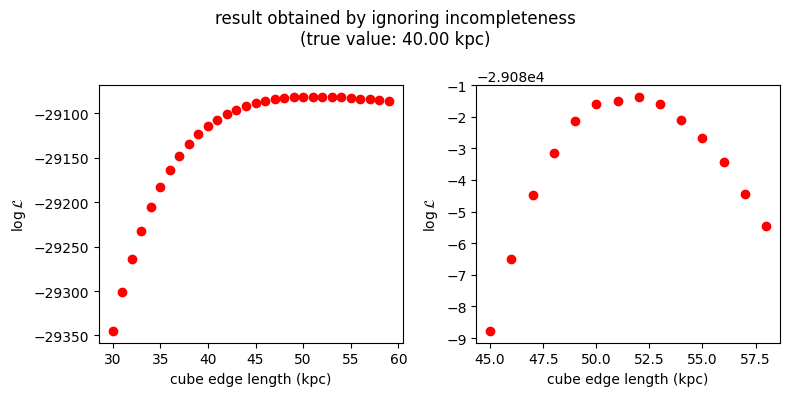

In [7]:
%%time

all_log_L_biased = []
for cubeSize in cube_sizes_to_try:

    density_on_grid = []
    # compute the normalisation constant:
    for ll_hpx,bb_hpx in zip(l_hpx, b_hpx):
        p_grid = probability_density_cube(ll_hpx, bb_hpx,cubeSize,Rsun=8)
        density_on_grid.append( p_grid )
    norm_constant = sum(density_on_grid)
    
    # compute the likelihood for all stars one by one:
    log_p = []
    for iii in range(len(incomplete_stars.l.value)):
        p = probability_density_cube(incomplete_stars.l.value[iii],incomplete_stars.b.value[iii],cubeSize,Rsun=8) 
        log_p.append( np.log(p/norm_constant) )
        
    all_log_L_biased.append( sum(log_p) )
    if cubeSize%5==0:
        print(cubeSize,norm_constant,sum(log_p))
all_log_L_biased = np.array(all_log_L_biased)



plt.figure(figsize=(8,4))

plt.subplot(121)
plt.scatter( cube_sizes_to_try , all_log_L_biased , c='r')   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

imax = np.argmax(all_log_L_biased)
plt.subplot(122)
plt.scatter( cube_sizes_to_try[imax-7:imax+7] , all_log_L_biased[imax-7:imax+7] , c='r')   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

plt.suptitle('result obtained by ignoring incompleteness\n(true value: %.2f kpc)' % (2*halfSizeCube))
plt.tight_layout()

The procedure is now returning incorrect results! We know the cube size is 40 kpc, but the incomplete data makes the stellar distribution more homogeneous on the sky (because it is more incomplete in the parts of the sky with a higher true density), which mimicks the effect of the cube being larger.

30 81483602.46232517 -28336.282743790205
35 132430391.85281473 -28237.42118866587
40 200816043.11599615 -28212.414267111824
45 289190360.5984642 -28217.36112678174
50 400085064.7191931 -28233.389282052754
55 535997898.4230762 -28252.30199528893
CPU times: user 33.7 s, sys: 132 ms, total: 33.8 s
Wall time: 33.8 s


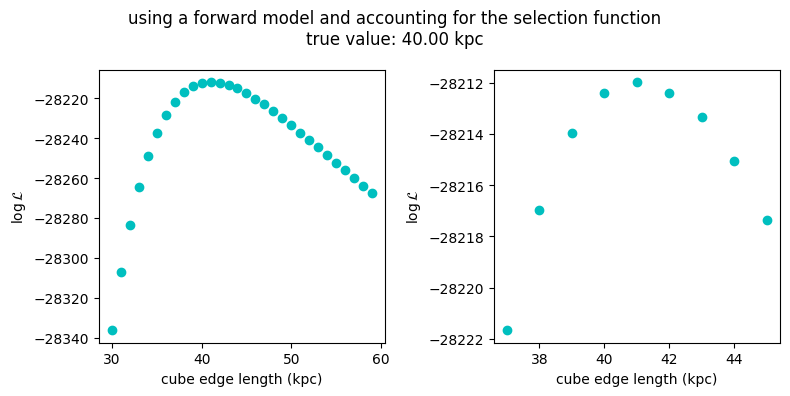

In [8]:
%%time

# precompute the selection function at points on the grid
completeness_grid = mapHpx7.query(SkyCoord(l=l_hpx, b=b_hpx, unit="deg", frame="galactic"),
                                  gmag*np.ones_like(l_hpx))


all_log_L_withsf = []
for cubeSize in cube_sizes_to_try:

    density_on_grid = []
    # compute the normalisation constant:
    for iii,(ll_hpx,bb_hpx) in enumerate(zip(l_hpx, b_hpx)):
        p_grid = probability_density_cube(ll_hpx, bb_hpx,cubeSize,Rsun=8)
        density_on_grid.append( p_grid * completeness_grid[iii] )
    norm_constant = sum(density_on_grid)
    
    # compute the likelihood for all stars one by one:
    log_p = []
    for iii in range(len(incomplete_stars.l.value)):
        p = probability_density_cube(incomplete_stars.l.value[iii],incomplete_stars.b.value[iii],cubeSize,Rsun=8) 
        p_sf = completeness[is_selected][iii]
        log_p.append( np.log(p*p_sf/norm_constant) )
        
    all_log_L_withsf.append( sum(log_p) )
    if cubeSize%5==0:
        print(cubeSize,norm_constant,sum(log_p))
all_log_L_withsf = np.array(all_log_L_withsf)


plt.figure(figsize=(8,4))

plt.subplot(121)
plt.scatter( cube_sizes_to_try , all_log_L_withsf , c='c')   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

imax = np.argmax(all_log_L_withsf)
plt.subplot(122)
plt.scatter( cube_sizes_to_try[imax-4:imax+5] , all_log_L_withsf[imax-4:imax+5] , c='c')   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

plt.suptitle('using a forward model and accounting for the selection function\ntrue value: %.2f kpc' % (2*halfSizeCube))
plt.tight_layout()

# Can I use the selection function to correct the data?

No.

It is tempting, but in general you really shouldn't do this. 

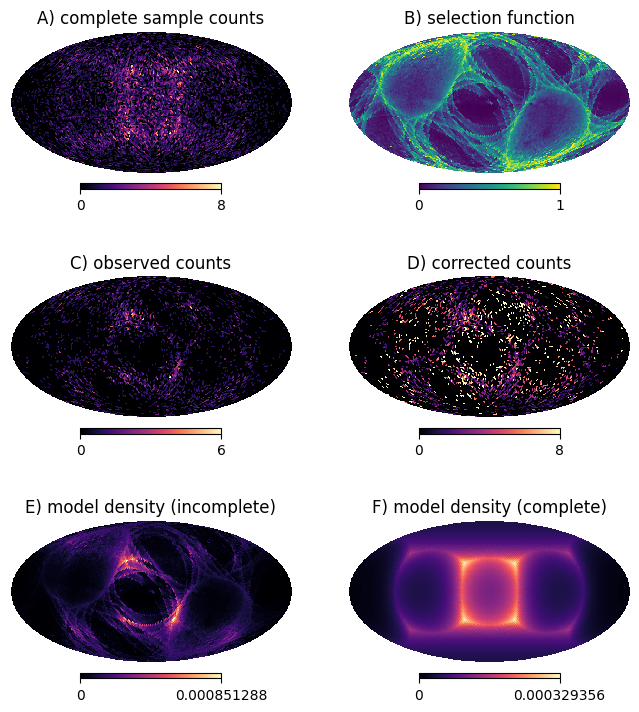

In [9]:
# Use a larger healpix gris than above, to have less noise in corrected counts:
import healpy as hp
order = 5
nside = hp.order2nside(order)
npix = hp.order2npix(order)
ipix = np.arange(npix)
l_hpx, b_hpx = hp.pix2ang(nside, ipix, lonlat=True)
completeness_grid = mapHpx7.query(SkyCoord(l=l_hpx, b=b_hpx, unit="deg", frame="galactic"),
                                  gmag*np.ones_like(l_hpx))


plt.figure(figsize=(8,9))

plt.subplot(321)
# count sources in each hpx:
ipix_true = hp.ang2pix(nside, all_stars_Galactic.l.value, all_stars_Galactic.b.value , lonlat=True)
counts_true = []
for iii in ipix:
    counts_true.append( len(ipix_true[ipix_true==iii]) )
counts_true = np.array(counts_true)
hp.mollview(counts_true,hold=True,title='A) complete sample counts',cmap='magma')



plt.subplot(322)
hp.mollview(completeness_grid,hold=True,title='B) selection function',min=0,max=1)


plt.subplot(323)
# count sources in each hpx:
ipix_observed = hp.ang2pix(nside, incomplete_stars.l.value, incomplete_stars.b.value , lonlat=True)
counts_observed = []
for iii in ipix:
    counts_observed.append( len(ipix_observed[ipix_observed==iii]) )
counts_observed = np.array(counts_observed)
hp.mollview(counts_observed,hold=True,title='C) observed counts',cmap='magma')

plt.subplot(324)
corrected_counts = counts_observed/completeness_grid
hp.mollview(corrected_counts,hold=True,title='D) corrected counts',
            min=min(counts_true),max=max(counts_true),cmap='magma')






plt.subplot(325)
density_on_grid = []
# compute the normalisation constant:
for iii,(ll_hpx,bb_hpx) in enumerate(zip(l_hpx, b_hpx)):
    p_grid = probability_density_cube(ll_hpx, bb_hpx,2*halfSizeCube,Rsun=8)
    density_on_grid.append( p_grid*completeness_grid[iii] )
norm_constant = sum(density_on_grid)
hp.mollview(np.array(density_on_grid)/norm_constant,hold=True,title='E) model density (incomplete)',min=0,
           cmap='magma')




plt.subplot(326)
density_on_grid = []
# compute the normalisation constant:
for ll_hpx,bb_hpx in zip(l_hpx, b_hpx):
    p_grid = probability_density_cube(ll_hpx, bb_hpx,2*halfSizeCube,Rsun=8)
    density_on_grid.append( p_grid )
norm_constant = sum(density_on_grid)
hp.mollview(np.array(density_on_grid)/norm_constant,hold=True,title='F) model density (complete)',min=0,
           cmap='magma')


The correct way to select the best-fit model is to compare panel C to panel E, for different choices of cube size.

The "count correction" approach compares panel D to panel F. The are many reasons not to do that:

* in regions that are so incomplete that you observe zero stars, the corrected number is still zero

* in regions that are very incomplete and have a few stars, the corrected values are noisy

This can be mitigated by the use of larger bins, but:

* when you bin your data you lose information

* the "corrected count" will not be an integer, so you won't be able to use mathematically sound tools like Poissonian statistics and you will have to take shortcuts

**Note:** In this notebook I randomly generate stars in my cube galaxy, then I randomly remove some of them to simulated incompleteness. The results can vary for each run, but the mathematically sound approach (forward modelling) always returns numbers close to the expected value, with a reasonable confidence interval. The correction approach tends to provide very peaked likelihoods (overestimating the precision) while peaking at the wrong value. In some unfortunate cases where corrections amplify noise too much, the likelihood may even diverge.

## Let's ignore the warnings and do the wrong thing anyway!

30 -25945.656820776083
35 -25483.651326797415
40 -25341.17960383194
45 -25320.734629402406
50 -25351.696496546083
55 -25403.854536527168
CPU times: user 29.2 s, sys: 749 ms, total: 30 s
Wall time: 29.5 s


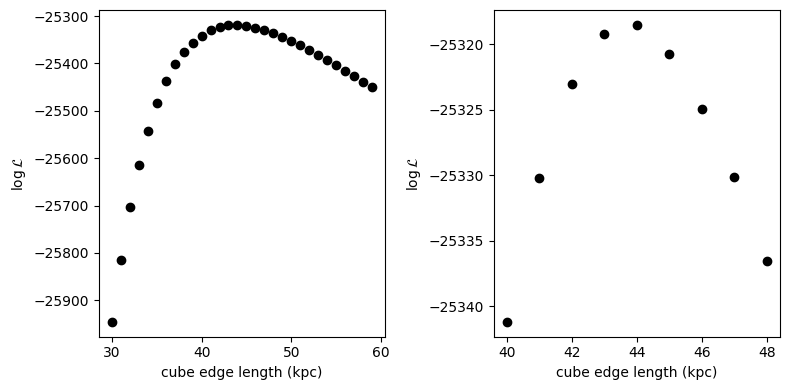

In [10]:
%%time
from scipy.stats import poisson

# round counts to nearest integer:
corrected_counts = (np.rint(corrected_counts)).astype(int)

all_log_L_correctedcounts = []
for cubeSize in cube_sizes_to_try:
    
    expected_counts = []
    for ll_hpx,bb_hpx in zip(l_hpx, b_hpx):
        p_grid = probability_density_cube(ll_hpx, bb_hpx,cubeSize)
        expected_counts.append( p_grid )
    
    # normalise the prediction so it contains the same number of stars as the observation:
    expected_counts = np.array(expected_counts) / np.sum(expected_counts)
    expected_counts = expected_counts * sum(corrected_counts)
    
    # log-likelihood for small counts:
    logL = sum([poisson.logpmf(ccc, eee) for ccc,eee in zip(corrected_counts,expected_counts) ])
    all_log_L_correctedcounts.append( logL )
    if cubeSize%5==0:
        print(cubeSize,logL)    
    
all_log_L_correctedcounts = np.array(all_log_L_correctedcounts)    
    
    
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.scatter( cube_sizes_to_try , all_log_L_correctedcounts , c='k')   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

imax = np.argmax(all_log_L_correctedcounts)
plt.subplot(122)
plt.scatter( cube_sizes_to_try[imax-4:imax+5] , all_log_L_correctedcounts[imax-4:imax+5] , c='k')   
plt.xlabel('cube edge length (kpc)')
plt.ylabel('$\log \mathcal{L}$')

#plt.suptitle('using a forward model and account for the selection function\ntrue value: %.2f kpc' % (2*halfSizeCube))
plt.tight_layout()

# Summary plot

Here we summarise the results we obtained through different methods. When using the complete sample of simulated stars, we easily recover the correct answer. Ignoring the the sample incompleteness provides a biased result. Accounting for the selection function in a forward model is the best approach: we recover the correct answer, albeit with larger uncertainties because we have a smaller number of stars that in the complete case.

(0.8, 4.2)

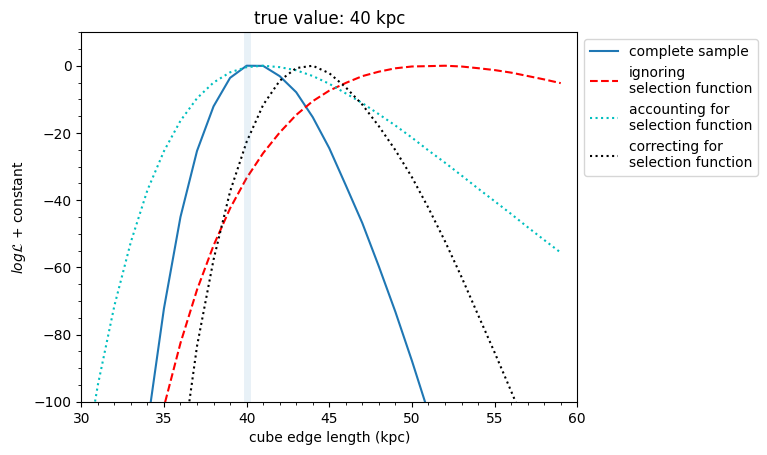

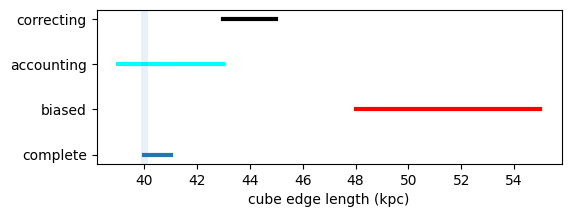

In [11]:
plt.figure()
plt.plot( cube_sizes_to_try , all_log_L - max(all_log_L) , c='C0' ,
         label='complete sample') 
plt.plot( cube_sizes_to_try , all_log_L_biased - max(all_log_L_biased) , 'r--' ,
         label='ignoring\nselection function') 
plt.plot( cube_sizes_to_try , all_log_L_withsf - max(all_log_L_withsf) , 'c:' ,
         label='accounting for\nselection function') 

plt.plot( cube_sizes_to_try , all_log_L_correctedcounts - max(all_log_L_correctedcounts) , 'k:',
         label='correcting for\nselection function') 



plt.xlim(30,60)
plt.ylim(-100,10)
plt.plot([2*halfSizeCube,2*halfSizeCube],[-100,10],lw=5,alpha=0.1)

plt.ylabel('$log \mathcal{L}$ + constant')
plt.xlabel('cube edge length (kpc)')
plt.minorticks_on()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('true value: %i kpc' % (2*halfSizeCube))




def find_95_percent_interval(loglikelihoods):
    """
    Input: numpy array of log-likelihood
    
    Output: boolean numpy array with True if a point is within the 95 percent confidence interval
    """
    sorted_likelihoods = sorted( np.exp(loglikelihoods-max(loglikelihoods)) )
    iii=1
    while sum(sorted_likelihoods[-iii:]) < 0.95*sum(sorted_likelihoods):
        iii+=1
        
    # the iii top points combine for over 95% of the likelihood
    # their indices are:
    ind = np.argpartition(loglikelihoods, -iii)[-iii:]
    
    mask95 = np.array([False for lll in loglikelihoods])
    mask95[ind] = True
    return mask95



plt.figure(figsize=(6,2))

mask95 = find_95_percent_interval(all_log_L)
plt.plot( cube_sizes_to_try[mask95] , 1.*np.ones_like(cube_sizes_to_try)[mask95] , c='C0', lw=3)

mask95 = find_95_percent_interval(all_log_L_biased)
plt.plot( cube_sizes_to_try[mask95] , 2.*np.ones_like(cube_sizes_to_try)[mask95] , c='r', lw=3)

mask95 = find_95_percent_interval(all_log_L_withsf)
plt.plot( cube_sizes_to_try[mask95] , 3.*np.ones_like(cube_sizes_to_try)[mask95] , c='cyan', lw=3)

mask95 = find_95_percent_interval(all_log_L_correctedcounts)
plt.plot( cube_sizes_to_try[mask95] , 4.*np.ones_like(cube_sizes_to_try)[mask95] , c='k', lw=3)

plt.plot([2*halfSizeCube,2*halfSizeCube],[-100,10],lw=5,alpha=0.1)

plt.yticks([1,2,3,4],['complete','biased','accounting','correcting'])
plt.xlabel('cube edge length (kpc)')
plt.ylim(0.8,4.2)